dt, rf, gbm, xgb, lgbm 기법 적용
- 피처 이름 적용: 현재 숫자임
- eda -> 이상치 확인
- 설명
    - 알고리즘
    - 파라미터
    - grid search cv 등
    - xgb, lgbm 구현

https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

https://pinkwink.kr/1252

https://dschloe.github.io/python/python_edu/04_machinelearning/ch02_gbm/

- 실험 대상: 19~48세 30명의 자원봉사자
- 허리에 스마트폰을 착용해 50Hz 주파수로 데이터 획득
    - 6가지 활동: walking, walking_upstairs, walking_downstairs, sitting, standing, laying
    

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

feature_name_df = pd.read_csv('../data/UCI_HAR_Dataset/features.txt', sep='\s+', header=None, names=['column_index', 'coulmn_name'])

feature_name = feature_name_df.iloc[:,1].values.tolist()
print(feature_name_df.info())
# print(feature_name_df.head())
# print(feature_name_df.iloc[:,1])
# print(feature_name_df.iloc[:,1].values)
# print(feature_name_df.iloc[:,1].values.tolist())
print('전체 피처명에서 10개만 추출', feature_name[:10])

#전체 피처명에서 10개만 추출 ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   column_index  561 non-null    int64 
 1   coulmn_name   561 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.9+ KB
None
전체 피처명에서 10개만 추출 ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


중복 피처 처리

In [3]:
feature_dup_df = feature_name_df.groupby('coulmn_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
print(feature_dup_df[feature_dup_df['column_index'] > 1].head())

column_index    42
dtype: int64
                              column_index
coulmn_name                               
fBodyAcc-bandsEnergy()-1,16              3
fBodyAcc-bandsEnergy()-1,24              3
fBodyAcc-bandsEnergy()-1,8               3
fBodyAcc-bandsEnergy()-17,24             3
fBodyAcc-bandsEnergy()-17,32             3


In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('coulmn_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # print(new_feature_name_df.info())
    
    new_feature_name_df['column_name'] = new_feature_name_df[['coulmn_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    # new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    # print(new_feature_name_df.info())
    return new_feature_name_df

In [5]:
import pandas as pd
def get_human_dataset():

    #각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../data/UCI_HAR_Dataset/features.txt', sep='\s+', header=None, names=['column_index', 'coulmn_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    #DataFrame에 피처명을 칼럼으로 부여하기 이해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    # print(new_feature_name_df.iloc[:,1])
    # print(new_feature_name_df.iloc[:,1].values)
    # print(new_feature_name_df.iloc[:,1].values.tolist())

    X_train = pd.read_csv('../data/UCI_HAR_Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('../data/UCI_HAR_Dataset/test/X_test.txt', sep='\s+', names=feature_name)

    y_train = pd.read_csv('../data/UCI_HAR_Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('../data/UCI_HAR_Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, 1 to 561
dtypes: float64(561)
memory usage: 31.5 MB
None


- 1: 

In [6]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,...,552,553,554,555,556,557,558,559,560,561
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [7]:
print(y_train['action'].value_counts())


6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


# Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Accuracy {0:.4f}'.format(accuracy))
print('Show all hyper parameter : ', dt_clf.get_params())


Accuracy 0.8548
Show all hyper parameter :  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [9]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [6,8,10,12,16,20,24, None]}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('Best Score: ', grid_cv.best_score_)
print('Best Hyper Parameter: ', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score:  0.8513444970102249
Best Hyper Parameter:  {'max_depth': 16}


In [10]:
#GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
print(cv_results_df.info())
print(cv_results_df[['param_max_depth', 'mean_test_score']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_fit_time      8 non-null      float64
 1   std_fit_time       8 non-null      float64
 2   mean_score_time    8 non-null      float64
 3   std_score_time     8 non-null      float64
 4   param_max_depth    7 non-null      object 
 5   params             8 non-null      object 
 6   split0_test_score  8 non-null      float64
 7   split1_test_score  8 non-null      float64
 8   split2_test_score  8 non-null      float64
 9   split3_test_score  8 non-null      float64
 10  split4_test_score  8 non-null      float64
 11  mean_test_score    8 non-null      float64
 12  std_test_score     8 non-null      float64
 13  rank_test_score    8 non-null      int32  
dtypes: float64(11), int32(1), object(2)
memory usage: 992.0+ bytes
None
  param_max_depth  mean_test_score
0               6      

In [11]:
# max_depth = 16

dt_clf = DecisionTreeClassifier(random_state=156, max_depth=16)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Accuracy {0:.4f}'.format(accuracy))
print('Show all hyper parameter : ', dt_clf.get_params())

Accuracy 0.8575
Show all hyper parameter :  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [12]:
max_depth = [6,8,10,12,16,20,24]
for depth in max_depth:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0}, accuracy = {1:.4f}'.format(depth, accuracy))

max_depth = 6, accuracy = 0.8558
max_depth = 8, accuracy = 0.8707
max_depth = 10, accuracy = 0.8673
max_depth = 12, accuracy = 0.8646
max_depth = 16, accuracy = 0.8575
max_depth = 20, accuracy = 0.8548
max_depth = 24, accuracy = 0.8548


In [13]:
#pip install graphviz

In [88]:
import numpy as np
np.unique(y_train['action'].values)

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [90]:
from sklearn.datasets import load_iris

iris = load_iris()

model = DecisionTreeClassifier(max_depth=3)         
model.fit(iris.data, iris.target)   

DecisionTreeClassifier(max_depth=3)

In [95]:
iris = pd.DataFrame(data = iris['data'], columns = iris['feature_names'])
iris.tail(1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
149,5.9,3.0,5.1,1.8


In [91]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [92]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [16]:
X_train.columns

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            552, 553, 554, 555, 556, 557, 558, 559, 560, 561],
           dtype='int64', length=561)

In [19]:
import numpy as np
target_arr = np.unique(y_train['action'].values)

In [22]:
target_str = np.array2string(target_arr)
target_str

'[1 2 3 4 5 6]'

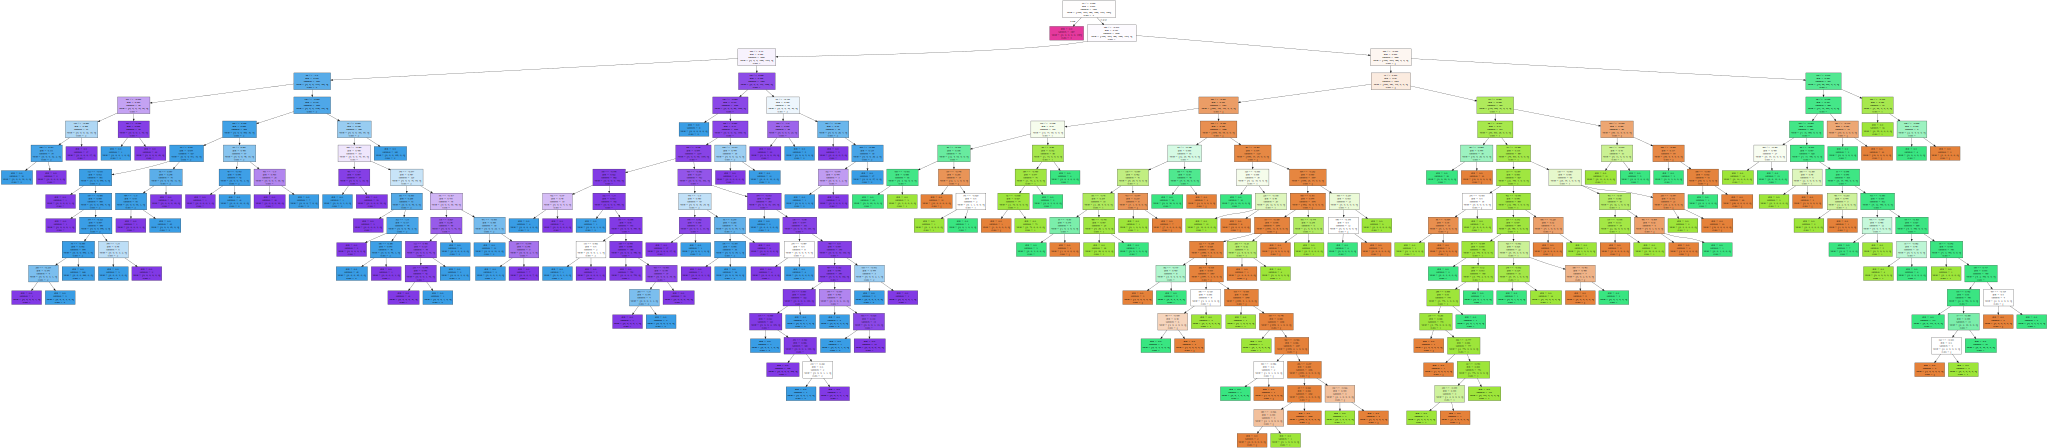

In [23]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file="tree.dot", class_names = target_str,
                feature_names = X_train.columns, impurity=True, filled=True)

import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

In [30]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_max_depth,mean_test_score
4,16,0.851344
2,10,0.851209
1,8,0.851069
5,20,0.850800
0,6,0.850791
6,24,0.849440
7,None,0.849440
3,12,0.844135


In [24]:
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치 ', grid_cv.best_score_)
print('GridSearchCV 최적 하이퍼 파라미터 ', grid_cv.best_params_)

best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('Accuracy :', accuracy)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치  0.8513444970102249
GridSearchCV 최적 하이퍼 파라미터  {'max_depth': 16}
Accuracy : 0.8574821852731591


# 가로로, 순서대로 수정

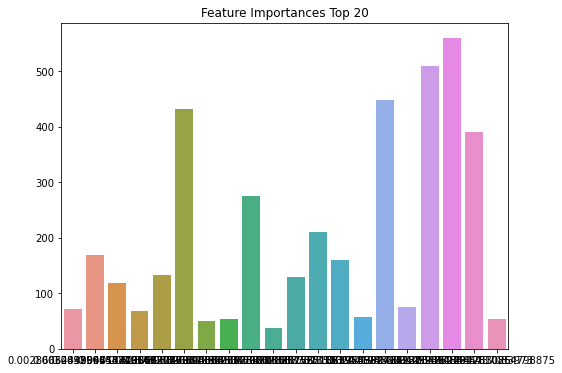

In [36]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances Top 20')

sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'max_depth' : [ 6, 8 ,10],
    'n_estimators' : [50, 100, 200],
    'min_samples_leaf' : [8, 12],
    'min_samples_split' : [8, 12]
}

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

cv_results_df = pd.DataFrame(grid_cv.cv_results_)

target_col = ['rank_test_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth']
cv_results_df[target_col].sort_values('rank_test_score').head()

c:\Anaconda3\envs\python36\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
28,1,0.915125,100,10
25,1,0.915125,100,10
23,3,0.912813,200,8
20,3,0.912813,200,8
35,5,0.912541,200,10


# GBM

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [56]:
def get_clf_eval(y_test, y_pred, pred_proba=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [42]:
# GBM 수행 시간 측정을 위함. 시작 시간 설정.
import time
start_time = time.time()

from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=10, # 기본값은 100이지만, 수업 시간을 고려하여 10으로 지정하였음
                                    validation_fraction=0.2,
                                    n_iter_no_change=5, tol=0.01, verbose = 1,
                                    random_state=0)
    
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

      Iter       Train Loss   Remaining Time 
         1           1.4069           31.65s
         2           1.1662           29.53s
         3           0.9894           26.21s
         4           0.8471           22.74s
         5           0.7366           19.18s
         6           0.6445           15.43s
         7           0.5673           11.63s
         8           0.5033            7.82s
         9           0.4466            3.92s
        10           0.3981            0.00s
GBM 정확도: 0.8907
GBM 수행 시간: 39.2 초 


In [43]:
from sklearn.model_selection import GridSearchCV

start_time = time.time()

params = {
    'n_estimators':[10, 20], # 원 코드 100, 500
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1, n_jobs = -1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
      Iter       Train Loss   Remaining Time 
         1           1.4069            1.10m
         2           1.1662            1.14m
         3           0.9894            1.12m
         4           0.8471            1.07m
         5           0.7366           59.91s
         6           0.6445           55.98s
         7           0.5673           52.06s
         8           0.5033           47.96s
         9           0.4466           43.87s
        10           0.3981           39.76s
        20           0.1600            0.00s
최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 20}
최고 예측 정확도: 0.8921
GBM 수행 시간: 122.4 초 


In [44]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

GBM 정확도: 0.9077


# XGBoost

In [45]:
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [46]:
import xgboost as xgb
from xgboost import XGBClassifier

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)


# 하이퍼파라미터 설명

In [51]:
params = {'max_depth': 3,
          'eta': 0.1,
          ##################################### binary:logloss 등 여러 종류 설명
          'objective': 'reg:linear',
          #####################################
          'eval_metric': 'logloss',
          'early_steppings': 100
          }
num_rounds = 400

In [52]:
# eval : evaluation = test 데이터 세트
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round = num_rounds, 
                      early_stopping_rounds = 100, evals = wlist)

[15:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[15:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_steppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:-38.37852	eval-logloss:-36.56106
[1]	train-logloss:-83.81179	eval-logloss:-80.13632
[2]	train-logloss:-93.41020	eval-logloss:-88.28549
[3]	train-logloss:-95.52695	eval-logloss:-90.66060
[4]	train-logloss:-99.10071	eval-logloss:-94.87059
[5]	train-logloss:-99.73291	eval-logloss:-95.68598
[6]	train-logloss:-100.10801	eval-logloss:-96.11109
[7]	train-logloss:-100.68554	eval-logloss

In [54]:
pred_probs = xgb_model.predict(dtest)
print("predict 된 예측 확률값 10개")
print(np.round(pred_probs[:10], 3))

predict 된 예측 확률값 10개만 표시
[4.946 4.962 4.888 4.911 5.003 4.933 4.863 4.974 4.882 4.948]


In [55]:
print("predict 된 예측값 10개")
print(preds[:10])

predict 된 예측값 10개
[5 5 5 5 5 5 5 5 5 5]


In [57]:
# get_clf_eval(y_test, preds, pred_probs)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# LGBM

In [25]:
# pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [31]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400)

evals = [(X_test, y_test)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set = evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

c:\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Anaconda3\envs\python36\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Anaconda3\envs\python36\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's multi_logloss: 1.4404
[2]	valid_0's multi_logloss: 1.21574
[3]	valid_0's multi_logloss: 1.04795
[4]	valid_0's multi_logloss: 0.913299
[5]	valid_0's multi_logloss: 0.812686
[6]	valid_0's multi_logloss: 0.725964
[7]	valid_0's multi_logloss: 0.652995
[8]	valid_0's multi_logloss: 0.591598
[9]	valid_0's multi_logloss: 0.539383
[10]	valid_0's multi_logloss: 0.499944
[11]	valid_0's multi_logloss: 0.462273
[12]	valid_0's multi_logloss: 0.429676
[13]	valid_0's multi_logloss: 0.401908
[14]	valid_0's multi_logloss: 0.377718
[15]	valid_0's multi_logloss: 0.357455
[16]	valid_0's multi_logloss: 0.339918
[17]	valid_0's multi_logloss: 0.325799
[18]	valid_0's multi_logloss: 0.314716
[19]	valid_0's multi_logloss: 0.301914
[20]	valid_0's multi_logloss: 0.292755
[21]	valid_0's multi_logloss: 0.284754
[22]	valid_0's multi_logloss: 0.276745
[23]	valid_0's multi_logloss: 0.270387
[24]	valid_0's multi_logloss: 0.265765
[25]	valid_0's multi_logloss: 0.260089
[26]	valid_0's multi_logloss: 0.256178

# SVM

In [37]:
from sklearn import svm

In [45]:
classifier=svm.SVC()
parameters=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, 
            {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

model=GridSearchCV(classifier,parameters,n_jobs=-1,cv=4,verbose=4)
model.fit(X_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


c:\Anaconda3\envs\python36\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             verbose=4)

In [46]:
from sklearn.metrics import accuracy_score
ypred=model.predict(X_test)
accuracy=accuracy_score(y_test,ypred)

print('GridSearchCV 최고 평균 정확도 수치 ', grid_cv.best_score_)
print('GridSearchCV 최적 하이퍼 파라미터 ', grid_cv.best_params_)

best_df_svm = grid_cv.best_estimator_
pred_svm = best_df_svm.predict(X_test)
accuracy = accuracy_score(y_test, pred_svm)
print('Accuracy :', accuracy)

GridSearchCV 최고 평균 정확도 수치  0.8513444970102249
GridSearchCV 최적 하이퍼 파라미터  {'max_depth': 16}
Accuracy : 0.8574821852731591


시각화
https://jimmy-ai.tistory.com/32